In [38]:
import os
import glob
import IPython.display as ipd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

import librosa
import librosa.display as ld
import soundfile as sf

import pandas as pd
import torch

In [65]:
pd.set_option('display.max_rows', 500)

In [3]:
# jupyter kernel interrupt sends SIGINT so need to implement this manually for some reason
import signal, sys
terminate = False

def signal_handling(signum, frame):
    global terminate
    terminate = True


In [ ]:
'''
central moments:
    - mean, std_dev, skewness, and kurtosis of signal amplitude
zero crossing rate (quantify the "noisiness" of timbral texture):
    - divide entire signal into smaller frames
    - find num of zcr per frame (frame_length=2048)
    - feature: average + sigma of zcr across all frames
tempo:
    - librosa has a function for it (computes tempogram, estimates single value)
chroma features:
    - aggregate across frames --> mean + sigma

spectral centroid (geometric mean of fourier spectrum of audio signal, ie overall brightness or darkness of timbre)
rolloff frequency (similar to general brightness of song)
mel frequency cepstral coefficients(mimics human auditory spectrum in filtering spectrum)
RMS(amplitude in time domain, loudness measure)
spectral contrast:
    - diff btwn max and min magnitudes of frequencies
spectral bandwidth
spectral flatness
chromagram of power spectrogram
silence counting


'''

In [9]:
songs = []
curr_count = 0

# signal needs to be in this cell for the SIGINT to flow through (SIX YEAR OLD BUG??)
signal.signal(signal.SIGINT, signal_handling)

for fname in glob.glob("../youtubescraper/spotify_yt_data/*.flac"):
    try:
        if curr_count == 300:
            break
        if terminate:
            terminate=False
            break
        song_id = fname.split('/')[-1].split('.')[0]
        data, sr = sf.read(fname)

        # mono
        channel = 1

        # stereo
        if data.ndim == 2:
            data = (data[:,0] + data[:,1]) / 2
            channel = 2

        s = {
            'id': song_id,
            'signal': data,
            'sr': sr,
            'channel': channel
        }
        songs.append(s)
        curr_count += 1
    except:
        print(fname)
        continue
print(curr_count)

300


In [10]:
# probably need workflow to process current songs in batches
curr_songs = songs

In [15]:
metadata = pd.read_csv("./metadata.csv")
print(metadata.head())

            id              artist  \
0  l_7TWVX4EOk                 NaN   
1  fRPNEtRakns                 NaN   
2  BbgWSN95V8k  Rebirth Brass Band   
3  hJsOd3PWcAM      Gregory Isaacs   
4  XQF69A3oGjM              Koffee   

                                               title  duration  
0  Anarchy in the U.K. Lullaby Versions of Sex Pi...       215  
1  WITHOUT YOU (Workout Remix) by Power Music Wor...       221  
2                  Feel Like Funking It Up (Part II)       410  
3                     Gregory Isaacs - Long Sentence       221  
4              Koffee - W (Official Video) ft. Gunna       281  


In [41]:
# keeping one channel songs, everything is mono now, appending some metadata here
for s in curr_songs:
    s_metadata = metadata.loc[metadata['id'] == s['id']]
    s['artist'] = s_metadata['artist'].iloc[0]
    s['title'] = s_metadata['title'].iloc[0]
    s['duration'] = s_metadata['duration'].iloc[0]
    

In [48]:
df = pd.DataFrame(curr_songs)
df

,id,signal,sr,channel,artist,title,duration
0,scbeMwGaYJs,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,2,I-Wayne,I Wayne - I need her in my arms,216
1,KZcVeJl6L80,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,2,"Antonio Lucio Vivaldi, Pražský komorní orchest...","Concerto for Guitar, Strings and Continuo in C...",176
2,dJ6I1WY-VAw,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,2,NaN,Check Yes or No - Lullaby Versions of George S...,332
3,EE94VcQ8xw0,"[-0.0002307295799255371, -0.000244915485382080...",48000,2,"Kevin Gates, Level",Get In There (feat. Level),243
4,ApGhG2YRCqA,"[1.2934207916259766e-05, 1.3887882232666016e-0...",48000,2,Shai Linne,Atonement Interlude 3,46


In [59]:
# max duration 8 minutes
df = df.loc[df['duration'] <= 480]

# min duration 4 minutes
df = df.loc[df['duration'] >= 240]

In [71]:
'''
for all librosa functions, using default params of:

sampling_rate=22050
frame_length=2048
hop_size=512 --> 75% overlap in windows
n_mels=20 ?
melbins_num=96
frequency_max=sampling_rate/2

also, just getting the mean of each feature for PCA/LDA
the 1-d cnn + attention will provide a more granular analysis

'''
# getting zero-crossing rate
df['zcr'] = np.mean(df['signal'].apply(librosa.feature.zero_crossing_rate))

ValueError: can't extend empty axis 0 using modes other than 'constant' or 'empty'

I Wayne - I need her in my arms
(10362602,)


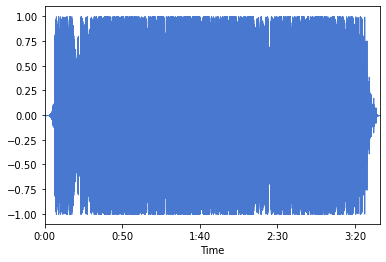

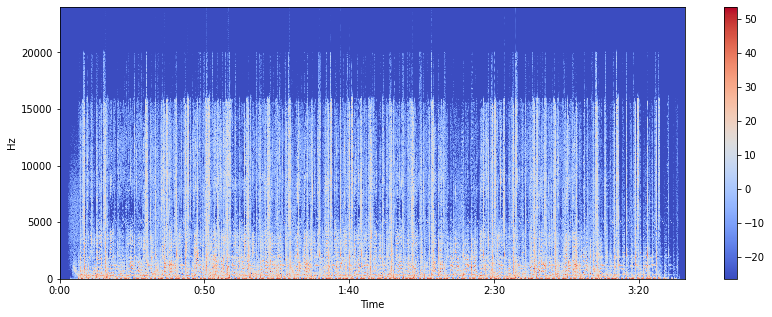

Concerto for Guitar, Strings and Continuo in C Major (Concerto con mandolino, archi e basso...
(8442880,)


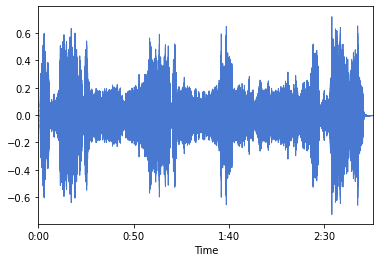

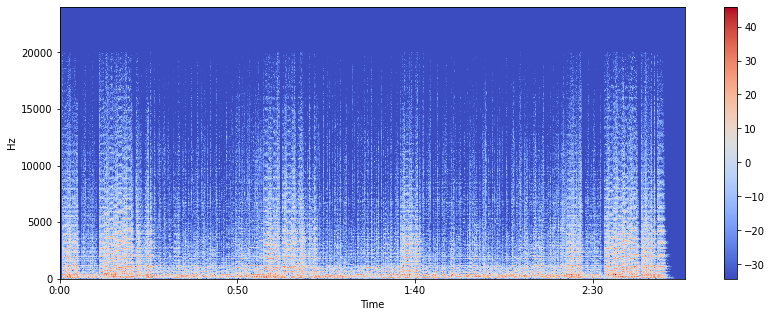

Check Yes or No - Lullaby Versions of George Strait by Twinkle Twinkle Little Rock Star
(15910871,)


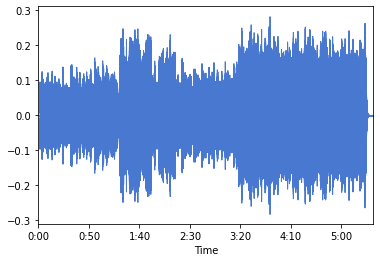

KeyboardInterrupt: 

In [46]:
for s in curr_songs:
    print(s['title'])
    signal, sr = s['signal'], s['sr']
    print(signal.shape)
    
    librosa.display.waveplot(signal, sr=sr)
    plt.show()
    
    X = librosa.stft(signal)
    X_db = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    ld.specshow(X_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    
    plt.show()
